# Detecting most common courseroads at EPFL

## Description

### Goal of the project

We aim to analyse in what progression do EPFL students usually take their classes, and compare this result with the official course prerequisites.

### Data source
We work the EPFL ISAcademia course registration data provided by Francisco Pinto (EPFL) and Patrick Jermann (EPFL). Each row of the data describes one course taken by one student in one particular semester. The official course prerequisites were provided by Francisco Pinto and were extraced from the official descriptions (http://cedegemac05.epfl.ch/apps/demos/catalog-graph/index.html)

### Methods

- We start by assigning a list of lists for each student. The higher level list shows the semesters the student took part in, and each item in this list contains a list of courses taken in this semester.
- We convert the list of lists above to a graph on the courses. The weight on edge (A->B) is the number of times a student took course B after course A weighted by the inverse of the number of semesters elapsed between these two events.
- This gives us a very dense graph. For visualization, we only show the top 3 incoming edges for each node. We colorcode the nodes based on which semester students usually take the particular course.
- For comparison with the official graph we calculate the percentage of edges there that appear in the list top 5 incoming edges for each node.
- For a more detailed analysis we compute the rank of each incoming edge in the official graph amongst all incoming edges calculated by our approach. For example if (A-> B) appears in the official graph and in our graph A has the highest weight of all incoming edges to B, then the rank is one. We plot a histogram of these ranks.

### Results

Our preliminary analysis shows that the course enrollments can be used to give reasonable estimate to the course enrollments.

## Workflow

In [30]:
import pandas as pd
from networkx.readwrite import json_graph
import json
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from graph_tool.all import *
import graph_tool as gt
pd.set_option("display.max_columns",500)
import re
import numpy as np

We read the data

In [2]:
courses=pd.read_csv("Course_Info.csv")

In [3]:
er=pd.read_csv("DataJamDays.csv",encoding="latin9")

Some courses are of the form XXX-000;XXX-001 or XXX-000(a), we transform these to XXX-000

In [4]:
def strip(x):
    x=re.sub(r'\(\w\)', '',x)
    x=re.sub(r';.+', '', x)
    return x
er["CourseCodes_pr"]=er.CourseCodes.map(strip)
er["Y+S"]=er["YearName"]+er["SemesterName"]
er.sort_values(by=["PersonID","Y+S",],inplace=True)

Each student is now transformed into a list of lists: the upper level list corresponds to semesters, the lower one to courses taken simultaniously.

In [5]:
gr=er.groupby(["PersonID","Y+S"]).CourseCodes_pr.apply(list).reset_index().groupby("PersonID").CourseCodes_pr.apply(list)

In [6]:
er.loc[er.PersonID=="000233c365fae5994637f7d14d931f04"].head()

,CourseEnrolmentID,PersonID,SubjectID,YearName,SemesterName,Session,SubjectName,LevelName,TeachingLanguage,StudyDomain,CourseCodes,CourseCodes_pr,Y+S
4627,a4124ead04e97c9307e63d5a65a35048,000233c365fae5994637f7d14d931f04,67c8a4120162067fc333f60c806cdc29,2008-2009,Bachelor semestre 1,Session hiver,Chimie gnrale,Bachelor,franais,Chemistry,CH-161(a),CH-161,2008-2009Bachelor semestre 1
4628,a754f06d3305897067e7f1851a7ce82d,000233c365fae5994637f7d14d931f04,d84b49a29dfb129f310a97e78f0287e9,2008-2009,Bachelor semestre 1,Session hiver,Chimie organique (EPFL),Bachelor,franais,Chemistry,CH-162,CH-162,2008-2009Bachelor semestre 1
4629,32f8f96dfa4d541fb0d280eee0c66ddc,000233c365fae5994637f7d14d931f04,de43e84eb68eca6d856010319b020510,2008-2009,Bachelor semestre 1,Session hiver,Physique gnrale I,Bachelor,franais,Physics,PHYS-101(a),PHYS-101,2008-2009Bachelor semestre 1
39461,34d4bd667f85cfc6b70b8e58c95df40e,000233c365fae5994637f7d14d931f04,f2e7efd4f54c5fd05531f8d21461ca92,2008-2009,Bachelor semestre 2,Session t,"Algbre linaire I, II",Bachelor,franais,Mathematics,MATH-112;MATH-117,MATH-112,2008-2009Bachelor semestre 2
39462,e7c63e07a7c025f8ddf60c5aed6c8dc0,000233c365fae5994637f7d14d931f04,b7f60e641a9ed5b4a740bd57f01b8325,2008-2009,Bachelor semestre 2,Session t,"Analyse I, II",Bachelor,franais,Mathematics,MATH-106(c);MATH-101(b),MATH-106,2008-2009Bachelor semestre 2


In [7]:
gr.loc["000233c365fae5994637f7d14d931f04"]

[['CH-161', 'CH-162', 'PHYS-101'],
 ['MATH-112',
  'MATH-106',
  'BIO-101',
  'CH-111',
  'PHYS-106',
  'CS-110',
  'PHYS-110'],
 ['PHYS-101', 'MATH-101', 'CH-162', 'CH-161'],
 ['PHYS-101', 'MATH-101', 'CH-161', 'CH-162'],
 ['MATH-117', 'BIO-100', 'PHYS-106', 'BIO-111', 'MATH-106']]

Now we create a graph from each course to all courses taken in the future. The edge weights are determined by the time elapsed between taking the two courses.

In [8]:
weight=er[["CourseCodes_pr","SubjectID"]].groupby("CourseCodes_pr").SubjectID.count()

In [9]:
a={}
b={}
for row in gr.iteritems():
    for i in range(len(row[1])):
        for j in range(i+1,len(row[1])):
            for fro in row[1][i]:
                for to in row[1][j]:
                    if not fro in a:
                        a[fro]={}
                    if not to in a[fro]:
                        a[fro][to]=0
                    if not to in b:
                        b[to]={}
                    if not fro in b[to]:
                        b[to][fro]=0
                    a[fro][to]+=1.0/(j-i)
                    b[to][fro]+=1.0/(j-i)

In [10]:
import math
a2={}
for course in a.keys():
    a2[course]=pd.Series(a[course])
    
b2={}
for course in b.keys():
    temp=pd.DataFrame(pd.Series(b[course])).join(weight)
    b2[course]=temp[0]#/temp["SubjectID"].map(math.sqrt)   ## We experimented with normalizing the edge weigths by the popularity of the class, but the results were not better
   # b2[course]=pd.Series(b[course])

For each node, we take only its top 3 edge as the 3 main dependencies.

In [11]:
b3=[]
for course in b2.keys():
    temp=b2[course]/b2[course].sum()
    b3.append(" ".join([course]+list(temp.sort_values(ascending=False).head(3).index)))

We read the data into networkx which will turn it into a json.

In [12]:
G = nx.parse_adjlist(b3, nodetype = str,)
jdata=nx.node_link_data(G)

Unfortunately, the json is not fully compatible with the d3 code, we need to make the ids integers and the course codes labels.

In [13]:
jdataS_nodes=json.dumps(jdata["nodes"])
jdataS_links=json.dumps(jdata["links"])

nodes_list=list(map(lambda x: x["id"], jdata["nodes"]))
repl=dict(zip(nodes_list,range(len(nodes_list))))

jdataS_nodes='"'.join( [ str(repl.get(word,word))+'", "label": "'+word if word in repl else word for word in jdataS_nodes.split('"')] )
jdataS_links='"'.join( [ str(repl.get(word,word)) for word in jdataS_links.split('"')] )

jdata_nodes=json.loads(jdataS_nodes)
jdata_links=json.loads(jdataS_links)

def to_int_nodes(x):
    x["id"]=int(x["id"])
    return x

def to_int_links(x):
    x["source"]=int(x["source"])
    x["target"]=int(x["target"])
    return x

import copy
jdata2=copy.deepcopy(jdata)
jdata2["directed"]=True
jdata2["nodes"]=list(map(to_int_nodes,jdata_nodes))
jdata2["links"]=list(map(to_int_links,jdata_links))


Adding colors based on which year this class is usually taken.

In [14]:
years=pd.read_csv("Course_YearNumber_Histogram.csv")
years["CourseCodes_pr"]=years.CourseCodes.map(strip)
#years.groupby("CourseCodes_pr").Occurences.max()
years["Y+O"]=list(zip(years["YearNumber"],years["Occurences"]))
myears=years.groupby("CourseCodes_pr")["Y+O"].agg(lambda l: max(l,key=lambda x: x[1]))
myears=myears.map(lambda x: x[0]/4)

def add_scores(x):
    if x["label"] in myears:
        x["score"]=myears.loc[x["label"]]
    else:
        x["score"]=0
    return x

#def add_fx(x):
#    x["x"]=randint(1,10)
#    x["y"]=randint(1,10)    
#    return x

jdata2["nodes"]=list(map(add_scores,jdata2["nodes"]))
#jdata2["nodes"]=list(map(add_fx,jdata2["nodes"]))

Outputting the data.

In [15]:
with open("graph2.json","w") as f:
    f.write(json.dumps(jdata2))

The rest of the stuff is for visualization with graph-tool.

In [16]:
with open("graph.json") as f:
    js_graph = json.load(f)
#js_graph["links"]=js_graph["edges"]
oG=json_graph.node_link_graph(js_graph)

In [17]:
odf_l=pd.DataFrame(js_graph["links"])
odf_n=pd.DataFrame(js_graph["nodes"])

In [18]:
odf_l["for"]=odf_l["source"].map(lambda x: odf_n.loc[x].label)
odf_l["needed"]=odf_l["target"].map(lambda x: odf_n.loc[x].label)
odf_l["for"]=odf_l["for"].map(strip)
odf_l["needed"]=odf_l["needed"].map(strip)

odf_l["for_needed"]=list(zip(odf_l["for"].values,odf_l["needed"].values))


In [19]:
odf_l["found_rank"]=odf_l["for_needed"].map(lambda x:  pd.DataFrame(b2[x[0]]).sort_values(by=0,ascending=False).reset_index().reset_index().set_index("index").loc[x[1]].level_0+1 if x[0] in b2 and x[1] in b2[x[0]] else False)
odf_l["found"]=odf_l["for_needed"].map(lambda x: x[1] in b2[x[0]].sort_values(ascending=False).head(5) if x[0] in b2 else False)
odf_l["top3"]=odf_l["for"].map(lambda x: list(b2[x].sort_values(ascending=False).head(3).index) if x in b2 else False)

Percentage of edges in the ground truth found by our top5 estimate

In [35]:
odf_l.found_rank.replace(False,np.nan,inplace=True)
odf_l.found.sum()/odf_l.shape[0]

0.17739520958083832

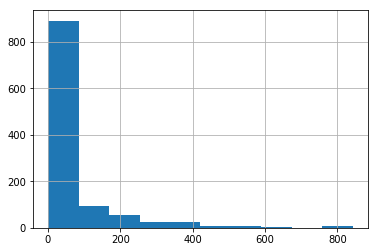

In [37]:
odf_l.found_rank.hist()

In [22]:
odf_l.head()

,label,source,target,for,needed,for_needed,found_rank,found,top3
0,REQUIRE_IND,0,591,MATH-126,MATH-120,"(MATH-126, MATH-120)",157,False,"[MATH-184, MATH-124, AR-123]"
1,REQUIRE_IND,0,591,MATH-126,MATH-120,"(MATH-126, MATH-120)",157,False,"[MATH-184, MATH-124, AR-123]"
2,REQUIRE_IND,0,1317,MATH-126,MATH-121,"(MATH-126, MATH-121)",87,False,"[MATH-184, MATH-124, AR-123]"
3,REQUIRE_IND,0,1317,MATH-126,MATH-121,"(MATH-126, MATH-121)",87,False,"[MATH-184, MATH-124, AR-123]"
4,REQUIRE_OBL,2,824,EE-207,EE-206,"(EE-207, EE-206)",1,True,"[EE-206, EE-202, PHYS-201]"


Graph tool stuff

In [38]:
def draw(G): 
    plt.figure(figsize=(50,50))
    text=G.vertex_index
    plt.switch_backend('cairo')  # the only supported backend
    plt.figure(figsize=(20,20))
    pos = gt.draw.sfdp_layout(G,groups=vprop_double)
    
    gt.draw.graph_draw(G,vertex_fill_color=vprop_double , pos=pos,vertex_font_size=5)
#vertex_text=text,

In [39]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, bytes):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG


In [40]:
gtG = nx2gt(G)

In [41]:
vprop_double = gtG.new_vertex_property("int")
vprop_double.get_array()[:]=list(map(lambda x: x["score"]*4, jdata2["nodes"]))

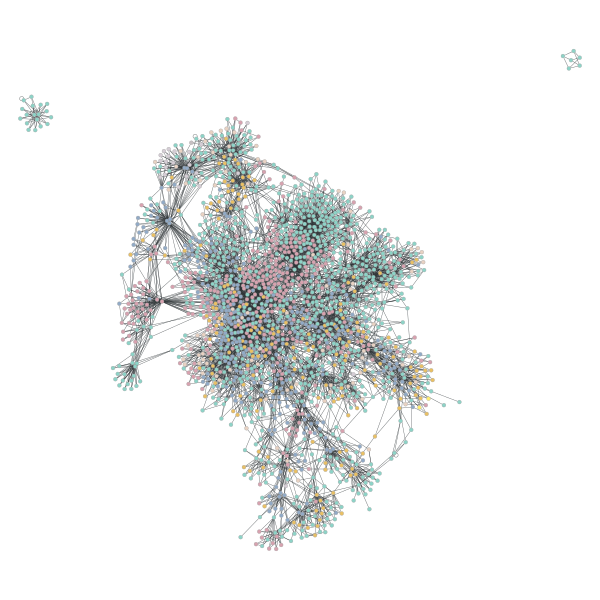

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fdad8843390, at 0x7fdad88bd320>

In [42]:
plt.figure(figsize=(50,50))
text=gtG.vertex_index
plt.switch_backend('cairo')  # the only supported backend
plt.figure(figsize=(20,20))
pos = gt.draw.sfdp_layout(gtG,groups=vprop_double)

#for v in range(1998):
#    pos[gtG.vertex(v)][0]=list(map(lambda x: x["score"]*4, jdata2["nodes"]))[v]
    
gt.draw.graph_draw(gtG,vertex_fill_color=vprop_double , pos=pos,vertex_font_size=5)

In [43]:
for i in range(10):
    for v in range(gtG.num_vertices()):
        pos[gtG.vertex(v)][0]=list(map(lambda x: x["score"]*4, jdata2["nodes"]))[v]
    pos = gt.draw.sfdp_layout(gtG,groups=vprop_double,pos=pos,max_iter=5)

In [44]:
for v in range(1998):
    pos[gtG.vertex(v)][0]=list(map(lambda x: x["score"]*4, jdata2["nodes"]))[v]

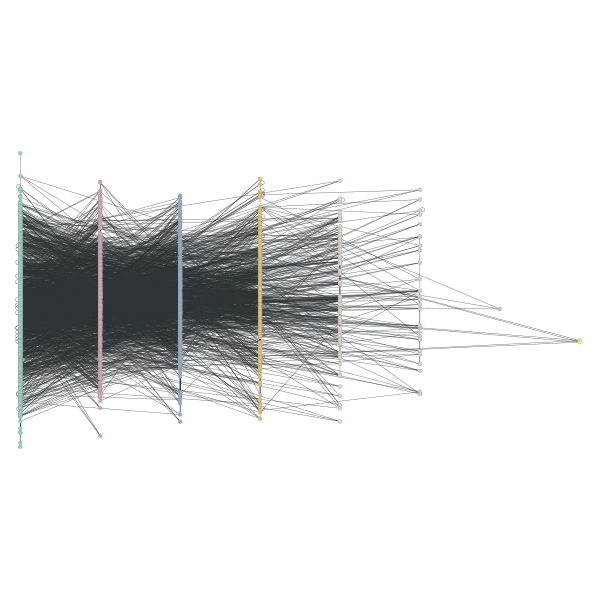

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fdad8843390, at 0x7fdad5ab44e0>

In [45]:
plt.figure(figsize=(50,50))
text=gtG.vertex_index
plt.switch_backend('cairo')  # the only supported backend
plt.figure(figsize=(20,20))
#pos = gt.draw.sfdp_layout(gtG,groups=vprop_double)

#for v in range(1998):
#    pos[gtG.vertex(v)][0]=list(map(lambda x: x["score"]*4, jdata2["nodes"]))[v]
    
gt.draw.graph_draw(gtG,vertex_fill_color=vprop_double , pos=pos,vertex_font_size=5)
